# Calibration Tutorial - Fort Peck, MT - Unirrigated Flux Plot

## Step 1: Uncalibrated Model Run

This tutorial focuses on calibrating SWIM-RS for a single unirrigated plot: a 3-pixel buffer around FluxNet's US-FPe eddy covariance station from John Volk's Flux ET benchmark dataset. The flux station provides independent observations of both meteorology and ET flux, allowing us to validate our model.

This notebook demonstrates:
1. Loading pre-built model input data from a SwimContainer
2. Running the uncalibrated SWIM model
3. Comparing model output with flux tower observations

**Reference:** This example is based on John Volk's flux footprint study:
- Paper: https://www.sciencedirect.com/science/article/pii/S0168192323000011
- Data: https://www.sciencedirect.com/science/article/pii/S2352340923003931

---

### Data Pipeline

**Input Data:** The `data/2_Fort_Peck.swim/` container stores pre-computed input data, so you can get started right away. If you want to build or rebuild the data for this example, we have provided scripts for reproduction:

1. **Extract data** from Earth Engine and GridMET:
   ```bash
   cd data/
   python extract_data.py           # Extract US-FPe only (default)
   python extract_data.py --help    # See all options
   ```

2. **Sync from bucket** after EE tasks complete:
   ```bash
   gsutil -m rsync -r gs://wudr/2_Fort_Peck/ ./data/
   ```

3. **Build model inputs** using the container:
   ```bash
   cd data/
   python build_inputs.py           # Build container
   python build_inputs.py --rebuild # Force rebuild from scratch
   ```

The container (`data/2_Fort_Peck.swim/`) stores all ingested data with provenance tracking.

---

In [1]:
import os
import sys
import time
import tempfile
import zipfile

import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score

root = os.path.abspath('../..')
sys.path.append(root)

from swimrs.swim.config import ProjectConfig
from swimrs.container import SwimContainer
from swimrs.process.input import build_swim_input
from swimrs.process.loop_fast import run_daily_loop_fast
from swimrs.process.loop import run_daily_loop

from swimrs.viz.swim_timeseries import plot_swim_timeseries

%matplotlib inline

## 1. Project Setup

Define paths and unzip pre-built data if needed.

In [2]:
project_ws = os.path.abspath('.')
data = os.path.join(project_ws, 'data')

config_file = os.path.join(project_ws, '2_Fort_Peck.toml')
container_path = os.path.join(data, '2_Fort_Peck.swim')

# Unzip flux tower data if needed
flux_zip = os.path.join(data, 'US-FPe_daily_data.zip')
flux_csv = os.path.join(data, 'US-FPe_daily_data.csv')

if os.path.exists(flux_zip) and not os.path.exists(flux_csv):
    print("Extracting US-FPe_daily_data.zip...")
    with zipfile.ZipFile(flux_zip, 'r') as z:
        z.extractall(data)

print(f"Project workspace: {project_ws}")
print(f"Config file: {config_file}")
print(f"Container: {container_path}")

Project workspace: /home/dgketchum/code/swim-rs/examples/2_Fort_Peck
Config file: /home/dgketchum/code/swim-rs/examples/2_Fort_Peck/2_Fort_Peck.toml
Container: /home/dgketchum/code/swim-rs/examples/2_Fort_Peck/data/2_Fort_Peck.swim


In [3]:
# Load the project configuration
config = ProjectConfig()
config.read_config(config_file, project_ws)

### Optional: Query Data from Container

The SwimContainer provides direct access to ingested data for exploration and analysis.
This is useful for inspecting data without running the full model.

In [4]:
# Example: Query data directly from the SwimContainer
from swimrs.container import SwimContainer

container_path = os.path.join(data, '2_Fort_Peck.swim')

if os.path.exists(container_path):
    container = SwimContainer.open(container_path, mode='r')

    # List available fields
    print(f"Fields in container: {container.field_uids}")

    # Get all time series for a single field using field_timeseries
    ts_df = container.query.field_timeseries('US-FPe')
    print(f"\nTime series shape: {ts_df.shape}")
    print(f"Variables: {list(ts_df.columns)[:10]}...")

    # Query specific data using dataframe with zarr paths
    # Path structure: remote_sensing/{type}/{instrument}/{model}/{mask}
    ndvi_df = container.query.dataframe("remote_sensing/ndvi/landsat/inv_irr", fields=['US-FPe'])
    print(f"\nNDVI observations: {ndvi_df.notna().sum().values[0]}")

    etf_df = container.query.dataframe("remote_sensing/etf/landsat/ssebop/inv_irr", fields=['US-FPe'])
    print(f"ETf observations: {etf_df.notna().sum().values[0]}")

    # Show container status
    print("\n" + container.query.status())

    container.close()
else:
    print(f"Container not found at {container_path}")
    print("Run: cd data && python build_inputs.py --rebuild")

Fields in container: ['US-FPe']

Time series shape: (13149, 20)
Variables: ['meteorology_gridmet_etr_corr', 'meteorology_gridmet_u2', 'meteorology_gridmet_ea', 'meteorology_gridmet_tmax', 'meteorology_gridmet_eto_corr', 'meteorology_gridmet_eto', 'meteorology_gridmet_prcp', 'meteorology_gridmet_etr', 'meteorology_gridmet_tmin', 'meteorology_gridmet_srad']...

NDVI observations: 804
ETf observations: 788

CONTAINER STATUS
  URI: file:///home/dgketchum/code/swim-rs/examples/2_Fort_Peck/data/2_Fort_Peck.swim
  Storage: directory
  Fields: 1
  Date range: 1987-01-01 to 2022-12-31
  Days: 13149

DATA PATHS:
----------------------------------------

  derived/
    dynamics/gwsub_data: shape=(1,), 100.0% non-empty
    dynamics/irr_data: shape=(1,), 100.0% non-empty
    dynamics/kc_max: shape=(1,), 100.0% valid
    dynamics/ke_max: shape=(1,), 100.0% valid
    merged_ndvi/inv_irr: shape=(13149, 1), 6.1% valid
    merged_ndvi/irr: shape=(13149, 1), 0.0% valid

  geometry/
    area_m2: shape=(1,

## 2. About the Study Site

The US-FPe flux site is located at Fort Peck, Montana. We use a simple 150-meter buffer around the flux tower instead of the sophisticated flux footprint polygons from the Volk et al. study.

According to IrrMapper data, this location has never been irrigated, making it ideal for testing non-irrigated model parameterization.

Site: US-FPe
Number of fields: 1


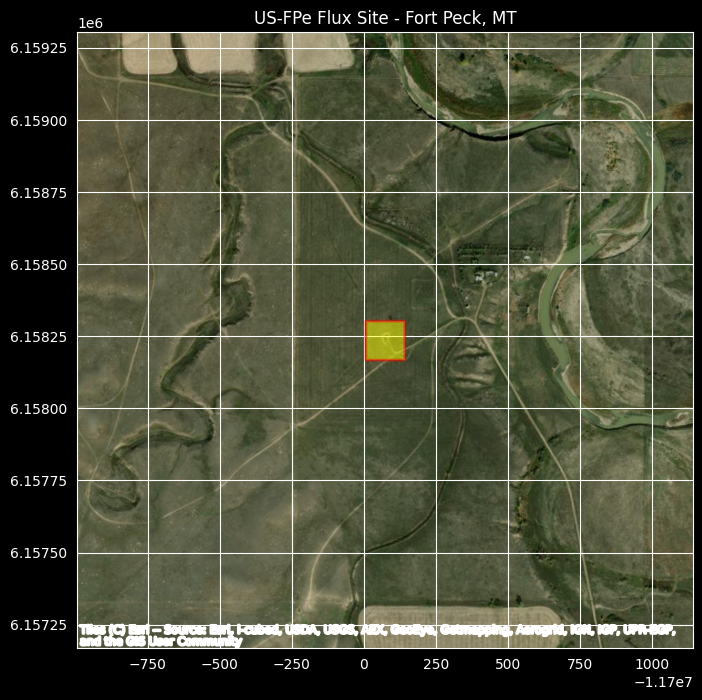

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt

import contextily as ctx

gdf = gpd.read_file(config.fields_shapefile)
selected_feature = 'US-FPe'

print(f"Site: {selected_feature}")
print(f"Number of fields: {len(gdf)}")

# Plot the study area
fig, ax = plt.subplots(figsize=(8, 8))
gdf_plot = gdf.to_crs(epsg=3857)
gdf_plot.plot(ax=ax, edgecolor='red', facecolor='yellow', alpha=0.5, linewidth=2)

# Zoom out by expanding bounds (5km buffer around site)
bounds = gdf_plot.total_bounds
buffer = 1000  # buffer in meters
ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

ax.set_title(f'US-FPe Flux Site - Fort Peck, MT')
plt.show()

## 3. Run the Uncalibrated Model

### Initial Parameter Values

Before running the model, let's examine the default parameter values and their bounds. These parameters control the soil water balance and ET partitioning:

In [6]:
# Display default parameter values and bounds
# These are the parameters that can be calibrated with PEST++

def show_parameter_table():
    """Display parameter bounds and initial values."""
    # Static parameter definitions (from PestBuilder.initial_parameter_dict)
    params = {
        'aw': {'initial_value': None, 'lower_bound': 100.0, 'upper_bound': 400.0, 'std': 50.0},
        'ks_alpha': {'initial_value': 0.5, 'lower_bound': 0.01, 'upper_bound': 1.0, 'std': 0.15},
        'kr_alpha': {'initial_value': 0.5, 'lower_bound': 0.01, 'upper_bound': 1.0, 'std': 0.15},
        'ndvi_k': {'initial_value': 7.0, 'lower_bound': 4.0, 'upper_bound': 10.0, 'std': 0.75},
        'ndvi_0': {'initial_value': 0.4, 'lower_bound': 0.1, 'upper_bound': 0.7, 'std': 0.25},
        'mad': {'initial_value': None, 'lower_bound': 0.01, 'upper_bound': 0.9, 'std': 0.15},
        'swe_alpha': {'initial_value': 0.3, 'lower_bound': -0.5, 'upper_bound': 1.0, 'std': 0.2},
        'swe_beta': {'initial_value': 1.5, 'lower_bound': 0.5, 'upper_bound': 2.5, 'std': 0.3},
    }

    print("=" * 80)
    print("INITIAL PARAMETER VALUES AND BOUNDS")
    print("=" * 80)
    print(f"{'Parameter':<12} {'Initial':>12} {'Lower':>10} {'Upper':>10} {'Std':>8}  Description")
    print("-" * 80)

    descriptions = {
        'aw': 'Available water capacity (mm)',
        'ks_alpha': 'Soil evap stress damping',
        'kr_alpha': 'Root zone stress damping',
        'ndvi_k': 'NDVI-Kcb slope',
        'ndvi_0': 'NDVI-Kcb intercept',
        'mad': 'Management allowable depletion',
        'swe_alpha': 'Snow melt temp coefficient',
        'swe_beta': 'Snow melt rate coefficient',
    }

    for name, p in params.items():
        init = p['initial_value']
        if init is None:
            init_str = 'auto'
        else:
            init_str = f"{init:.2f}"
        print(
            f"{name:<12} {init_str:>12} {p['lower_bound']:>10.2f} {p['upper_bound']:>10.2f} {p['std']:>8.2f}  {descriptions.get(name, '')}")

    print("=" * 80)
    print("\nNote: 'auto' values are computed from soil properties (awc) or defaults (mad=0.6)")


show_parameter_table()

INITIAL PARAMETER VALUES AND BOUNDS
Parameter         Initial      Lower      Upper      Std  Description
--------------------------------------------------------------------------------
aw                   auto     100.00     400.00    50.00  Available water capacity (mm)
ks_alpha             0.50       0.01       1.00     0.15  Soil evap stress damping
kr_alpha             0.50       0.01       1.00     0.15  Root zone stress damping
ndvi_k               7.00       4.00      10.00     0.75  NDVI-Kcb slope
ndvi_0               0.40       0.10       0.70     0.25  NDVI-Kcb intercept
mad                  auto       0.01       0.90     0.15  Management allowable depletion
swe_alpha            0.30      -0.50       1.00     0.20  Snow melt temp coefficient
swe_beta             1.50       0.50       2.50     0.30  Snow melt rate coefficient

Note: 'auto' values are computed from soil properties (awc) or defaults (mad=0.6)


In [7]:
def run_fields(config, container, selected_feature, output_csv):
    """Run SWIM model using the process package and save output to CSV.
    
    Uses the modern process package workflow:
    1. Build SwimInput from container
    2. Run simulation with run_daily_loop_fast() for ~300x speedup
    3. Convert DailyOutput to DataFrame with time series
    4. Add ETf observations from container for comparison
    """
    start_time = time.time()

    # Create temporary HDF5 for SwimInput
    with tempfile.NamedTemporaryFile(suffix='.h5', delete=False) as tmp:
        temp_h5_path = tmp.name
    
    try:
        # Build SwimInput from container
        swim_input = build_swim_input(
            container,
            output_h5=temp_h5_path,
            runoff_process=getattr(config, 'runoff_process', 'cn'),
            etf_model=getattr(config, 'etf_target_model', 'ptjpl'),
            met_source=getattr(config, 'met_source', 'gridmet'),
            fields=[selected_feature],
        )
        
        # Run simulation using the fast JIT-compiled loop
        output, final_state = run_daily_loop(swim_input)
        
        # Get time series data
        n_days = swim_input.n_days
        dates = pd.date_range(swim_input.start_date, periods=n_days, freq='D')
        
        # Get input time series for DataFrame
        etr = swim_input.get_time_series('etr')
        prcp = swim_input.get_time_series('prcp')
        tmin = swim_input.get_time_series('tmin')
        tmax = swim_input.get_time_series('tmax')
        ndvi = swim_input.get_time_series('ndvi')
        
        # Build DataFrame (field index 0 since we're doing single field)
        i = 0
        df_data = {
            # Model outputs
            'et_act': output.eta[:, i],
            'etref': etr[:, i],
            'kc_act': output.etf[:, i],
            'kc_bas': output.kcb[:, i],
            'ks': output.ks[:, i],
            'ke': output.ke[:, i],
            'melt': output.melt[:, i],
            'rain': output.rain[:, i],
            'depl_root': output.depl_root[:, i],
            'dperc': output.dperc[:, i],
            'runoff': output.runoff[:, i],
            'swe': output.swe[:, i],
            'irrigation': output.irr_sim[:, i],
            'gw_sim': output.gw_sim[:, i],
            # Input time series
            'ppt': prcp[:, i],
            'tmin': tmin[:, i],
            'tmax': tmax[:, i],
            'tavg': (tmin[:, i] + tmax[:, i]) / 2.0,
            'ndvi': ndvi[:, i],
        }
        
        # Calculate derived columns
        df_data['soil_water'] = swim_input.properties.awc[i] - output.depl_root[:, i]
        
        df = pd.DataFrame(df_data, index=dates)
        
        swim_input.close()
        
        # Load ETf observations from container for comparison
        # These are the remote sensing observations (PT-JPL in this example)
        etf_model = getattr(config, 'etf_target_model', 'ptjpl')
        for mask in ['inv_irr', 'irr']:
            etf_path = f"remote_sensing/etf/landsat/{etf_model}/{mask}"
            try:
                etf_df = container.query.dataframe(etf_path, fields=[selected_feature])
                # Align with simulation dates
                etf_series = etf_df[selected_feature].reindex(dates)
                df[f'etf_{mask}'] = etf_series.values
            except Exception as e:
                print(f"Warning: Could not load ETf for {mask}: {e}")
                df[f'etf_{mask}'] = np.nan
        
    finally:
        # Clean up temp file
        if os.path.exists(temp_h5_path):
            os.remove(temp_h5_path)
    
    end_time = time.time()
    print(f'\nExecution time: {end_time - start_time:.2f} seconds\n')

    df.to_csv(output_csv)
    
    return df

In [8]:
selected_feature = 'US-FPe'
out_csv = os.path.join(project_ws, f'combined_output_{selected_feature}_uncalibrated.csv')

# Open container for model run
container_path = os.path.join(data, '2_Fort_Peck.swim')
container = SwimContainer.open(container_path, mode='r')

try:
    df = run_fields(config, container, selected_feature=selected_feature, output_csv=out_csv)
finally:
    container.close()

/home/dgketchum/code/swim-rs/src/swimrs/process/loop.py:488: RuntimeWarning: invalid value encountered in divide
  etf = np.where(etr > 0, eta / etr, 0.0)



Execution time: 97.55 seconds



In [9]:
print(f"Output shape: {df.shape}")
print(f"\nKey output columns:")
key_cols = ['et_act', 'etref', 'kc_act', 'kc_bas', 'ks', 'ke', 'melt', 'rain',
            'depl_root', 'swe', 'ppt', 'irrigation', 'soil_water']
for col in key_cols:
    if col in df.columns:
        print(f"  {col}: mean={df[col].mean():.3f}, max={df[col].max():.3f}")

Output shape: (13149, 22)

Key output columns:
  et_act: mean=0.908, max=5.688
  etref: mean=2.720, max=12.026
  kc_act: mean=0.357, max=0.753
  kc_bas: mean=0.302, max=0.776
  ks: mean=0.676, max=1.000
  ke: mean=0.307, max=0.655
  melt: mean=0.115, max=21.709
  rain: mean=0.823, max=62.700
  depl_root: mean=27.366, max=103.989
  swe: mean=1.717, max=59.243
  ppt: mean=0.939, max=62.700
  irrigation: mean=0.000, max=0.000
  soil_water: mean=152.634, max=180.011


## 4. Visualize Model Output

Let's examine a single year (2004) to see the model's behavior.

In [10]:
ydf = df.loc['2004-01-01': '2004-12-31']
print(f'Total irrigation: {ydf.irrigation.sum():.1f} mm')
print(f'Total ET: {ydf.et_act.sum():.1f} mm')
print(f'Total precipitation: {ydf.ppt.sum():.1f} mm')

plot_swim_timeseries(ydf, ['et_act', 'etref', 'rain', 'melt', 'irrigation'],
                     start='2004-01-01', end='2004-12-31', png_dir='et_uncalibrated.png')

Total irrigation: 0.0 mm
Total ET: 328.3 mm
Total precipitation: 312.0 mm
et_uncalibrated.png


## 5. Compare with Flux Tower Observations

We compare three estimates of actual ET (mm/day):

1. **SWIM ET**: Model-estimated actual evapotranspiration (daily)
2. **PT-JPL ET**: Remote sensing retrievals from OpenET PT-JPL algorithm (ETf × ETo)
3. **Flux ET**: Independent observations from the eddy covariance tower (Volk et al.)

We show two comparisons:
- **Full time series**: SWIM (daily) vs PT-JPL (interpolated between Landsat dates) on all flux tower days
- **Capture dates only**: Both methods compared only on Landsat overpass dates

In [11]:
def compare_et_estimates(combined_output_path, flux_data_path, irr=False):
    """Compare model ET and PT-JPL ET against flux tower observations.
    
    Returns two comparison DataFrames:
    1. Capture dates only: Both methods on Landsat overpass dates only
    2. Full time series: SWIM daily, PT-JPL interpolated, on all flux tower days
    
    Reports R², Pearson r, bias, and RMSE for each comparison.
    """
    flux_data = pd.read_csv(flux_data_path, index_col='date', parse_dates=True)
    flux_et = flux_data['ET']  # Actual ET from flux tower (mm/day)

    output = pd.read_csv(combined_output_path, index_col=0)
    output.index = pd.to_datetime(output.index)

    etf_col = 'etf_irr' if irr else 'etf_inv_irr'

    # Calculate actual ET from PT-JPL: ETf × ETo (sparse, only on Landsat dates)
    ptjpl_et_sparse = output[etf_col] * output['etref']

    # Linear interpolation of PT-JPL to get daily values
    ptjpl_et_interp = ptjpl_et_sparse.interpolate(method='linear')

    # Count original PT-JPL observations
    n_ptjpl_obs = ptjpl_et_sparse.notna().sum()

    # CAPTURE DATES ONLY comparison (PT-JPL sparse)
    capture_df = pd.DataFrame({
        'swim_et': output['et_act'],
        'ptjpl_et': ptjpl_et_sparse,
        'flux_et': flux_et
    }).dropna()

    # FULL TIME SERIES comparison (PT-JPL interpolated)
    full_df = pd.DataFrame({
        'swim_et': output['et_act'],
        'ptjpl_et': ptjpl_et_interp,
        'flux_et': flux_et
    }).dropna()

    def calc_metrics(df, col1, col2):
        r, _ = stats.pearsonr(df[col1], df[col2])
        r2 = r2_score(df[col1], df[col2])
        rmse = np.sqrt(mean_squared_error(df[col1], df[col2]))
        bias = (df[col2] - df[col1]).mean()
        return r2, r, rmse, bias

    # Capture dates metrics
    r2_swim_cap, r_swim_cap, rmse_swim_cap, bias_swim_cap = calc_metrics(capture_df, 'flux_et', 'swim_et')
    r2_ptjpl_cap, r_ptjpl_cap, rmse_ptjpl_cap, bias_ptjpl_cap = calc_metrics(capture_df, 'flux_et', 'ptjpl_et')

    # Full time series metrics
    r2_swim_full, r_swim_full, rmse_swim_full, bias_swim_full = calc_metrics(full_df, 'flux_et', 'swim_et')
    r2_ptjpl_full, r_ptjpl_full, rmse_ptjpl_full, bias_ptjpl_full = calc_metrics(full_df, 'flux_et', 'ptjpl_et')

    print("=" * 70)
    print(f"CAPTURE DATES ONLY ({len(capture_df)} Landsat overpass dates)")
    print("=" * 70)
    print(f"{'Metric':<12} {'SWIM ET':>12} {'PT-JPL ET':>12}")
    print("-" * 38)
    print(f"{'R²':<12} {r2_swim_cap:>12.3f} {r2_ptjpl_cap:>12.3f}")
    print(f"{'Pearson r':<12} {r_swim_cap:>12.3f} {r_ptjpl_cap:>12.3f}")
    print(f"{'Bias (mm)':<12} {bias_swim_cap:>12.3f} {bias_ptjpl_cap:>12.3f}")
    print(f"{'RMSE (mm)':<12} {rmse_swim_cap:>12.3f} {rmse_ptjpl_cap:>12.3f}")

    print()
    print("=" * 70)
    print(f"FULL TIME SERIES ({len(full_df)} days, PT-JPL interpolated from {n_ptjpl_obs} obs)")
    print("=" * 70)
    print(f"{'Metric':<12} {'SWIM ET':>12} {'PT-JPL ET':>12}")
    print("-" * 38)
    print(f"{'R²':<12} {r2_swim_full:>12.3f} {r2_ptjpl_full:>12.3f}")
    print(f"{'Pearson r':<12} {r_swim_full:>12.3f} {r_ptjpl_full:>12.3f}")
    print(f"{'Bias (mm)':<12} {bias_swim_full:>12.3f} {bias_ptjpl_full:>12.3f}")
    print(f"{'RMSE (mm)':<12} {rmse_swim_full:>12.3f} {rmse_ptjpl_full:>12.3f}")

    return full_df, capture_df

In [12]:
flux_data = os.path.join(data, 'US-FPe_daily_data.csv')
full_df, capture_df = compare_et_estimates(out_csv, flux_data, irr=False)

CAPTURE DATES ONLY (161 Landsat overpass dates)
Metric            SWIM ET    PT-JPL ET
--------------------------------------
R²                  0.673        0.549
Pearson r           0.822        0.752
Bias (mm)          -0.050        0.170
RMSE (mm)           0.767        0.900

FULL TIME SERIES (1744 days, PT-JPL interpolated from 939 obs)
Metric            SWIM ET    PT-JPL ET
--------------------------------------
R²                  0.676        0.547
Pearson r           0.823        0.775
Bias (mm)          -0.041        0.282
RMSE (mm)           0.697        0.824


## Summary ##

The uncalibrated SWIM model shows moderate correlation with flux tower ET observations and relatively low bias. PT-JPL shows weaker correlation and tends to overestimate ET.

**Next step:** In notebook `02_calibration.ipynb`, we'll use PEST++ to calibrate the model parameters and improve performance.

**Note:** We're not using the flux data for calibration - it's only for validation. For calibration, we rely solely on widely-available remote sensing data (PT-JPL ETf and SNODAS SWE).

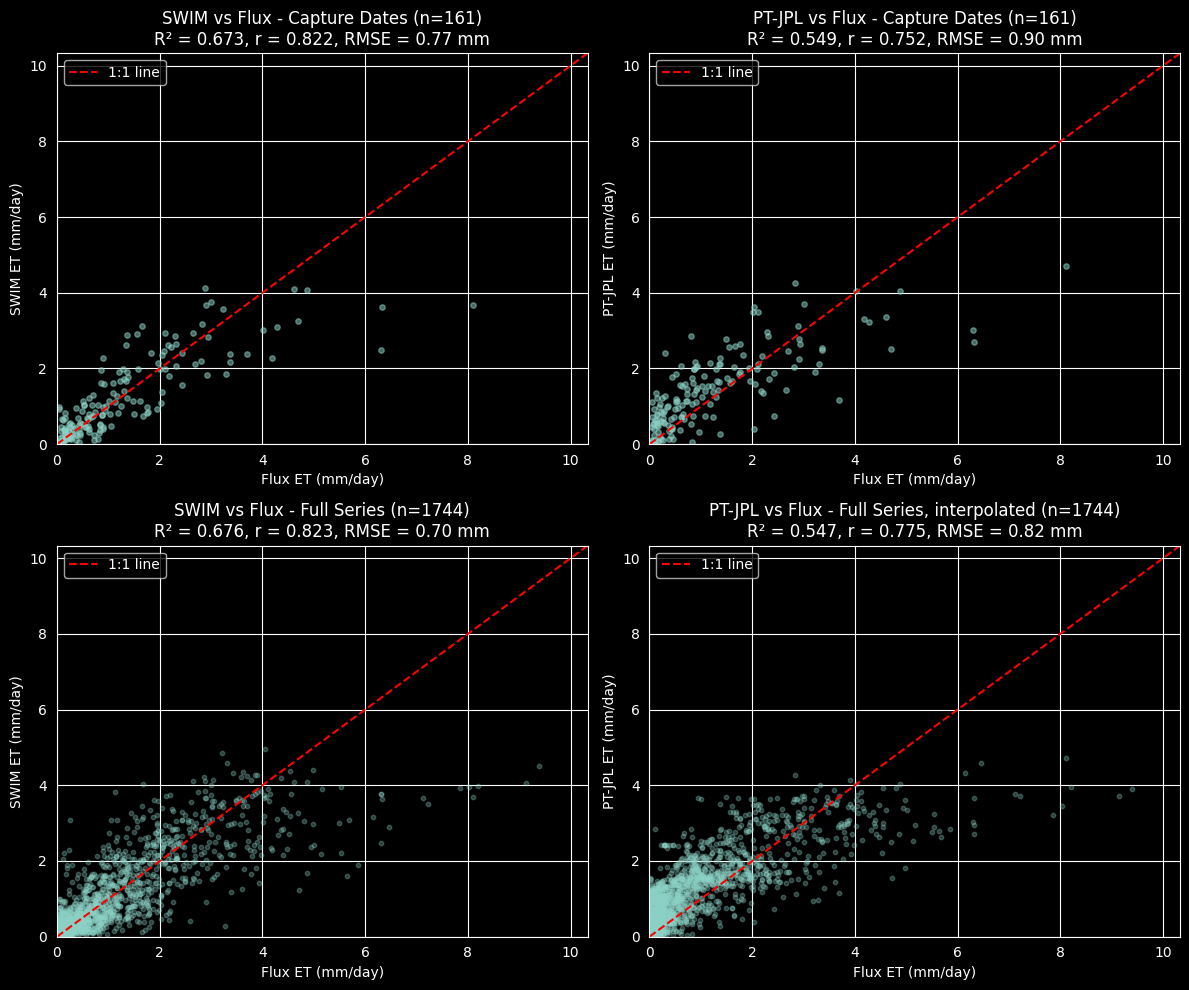

In [13]:
# Create scatter plots for both comparisons
fig, axes = plt.subplots(2, 2, figsize=(12, 10))


# Helper function to calculate metrics
def calc_metrics(df, col1, col2):
    r, _ = stats.pearsonr(df[col1], df[col2])
    r2 = r2_score(df[col1], df[col2])
    rmse = np.sqrt(mean_squared_error(df[col1], df[col2]))
    return r2, r, rmse


# Determine axis limits
max_et = max(full_df['flux_et'].max(), full_df['swim_et'].max(),
             full_df['ptjpl_et'].max()) * 1.1

# TOP ROW: Capture dates only
r2_swim_cap, r_swim_cap, rmse_swim_cap = calc_metrics(capture_df, 'flux_et', 'swim_et')
r2_ptjpl_cap, r_ptjpl_cap, rmse_ptjpl_cap = calc_metrics(capture_df, 'flux_et', 'ptjpl_et')

ax = axes[0, 0]
ax.scatter(capture_df['flux_et'], capture_df['swim_et'], alpha=0.5, s=15)
ax.plot([0, max_et], [0, max_et], 'r--', label='1:1 line')
ax.set_xlabel('Flux ET (mm/day)')
ax.set_ylabel('SWIM ET (mm/day)')
ax.set_title(f'SWIM vs Flux - Capture Dates (n={len(capture_df)})\n'
             f'R² = {r2_swim_cap:.3f}, r = {r_swim_cap:.3f}, RMSE = {rmse_swim_cap:.2f} mm')
ax.legend()
ax.set_xlim(0, max_et)
ax.set_ylim(0, max_et)

ax = axes[0, 1]
ax.scatter(capture_df['flux_et'], capture_df['ptjpl_et'], alpha=0.5, s=15)
ax.plot([0, max_et], [0, max_et], 'r--', label='1:1 line')
ax.set_xlabel('Flux ET (mm/day)')
ax.set_ylabel('PT-JPL ET (mm/day)')
ax.set_title(f'PT-JPL vs Flux - Capture Dates (n={len(capture_df)})\n'
             f'R² = {r2_ptjpl_cap:.3f}, r = {r_ptjpl_cap:.3f}, RMSE = {rmse_ptjpl_cap:.2f} mm')
ax.legend()
ax.set_xlim(0, max_et)
ax.set_ylim(0, max_et)

# BOTTOM ROW: Full time series comparison
r2_swim, r_swim, rmse_swim = calc_metrics(full_df, 'flux_et', 'swim_et')
r2_ptjpl, r_ptjpl, rmse_ptjpl = calc_metrics(full_df, 'flux_et', 'ptjpl_et')

ax = axes[1, 0]
ax.scatter(full_df['flux_et'], full_df['swim_et'], alpha=0.3, s=10)
ax.plot([0, max_et], [0, max_et], 'r--', label='1:1 line')
ax.set_xlabel('Flux ET (mm/day)')
ax.set_ylabel('SWIM ET (mm/day)')
ax.set_title(f'SWIM vs Flux - Full Series (n={len(full_df)})\n'
             f'R² = {r2_swim:.3f}, r = {r_swim:.3f}, RMSE = {rmse_swim:.2f} mm')
ax.legend()
ax.set_xlim(0, max_et)
ax.set_ylim(0, max_et)

ax = axes[1, 1]
ax.scatter(full_df['flux_et'], full_df['ptjpl_et'], alpha=0.3, s=10)
ax.plot([0, max_et], [0, max_et], 'r--', label='1:1 line')
ax.set_xlabel('Flux ET (mm/day)')
ax.set_ylabel('PT-JPL ET (mm/day)')
ax.set_title(f'PT-JPL vs Flux - Full Series, interpolated (n={len(full_df)})\n'
             f'R² = {r2_ptjpl:.3f}, r = {r_ptjpl:.3f}, RMSE = {rmse_ptjpl:.2f} mm')
ax.legend()
ax.set_xlim(0, max_et)
ax.set_ylim(0, max_et)

plt.tight_layout()
plt.savefig('comparison_scatter_uncalibrated.png', dpi=150)
plt.show()

## 6. Mass Balance Check

Verify water conservation across the full simulation period. The water balance equation:

**Starting Water + Inputs - Outputs = Ending Water**

Where:
- **Starting Water** = Initial Soil Water + Initial SWE
- **Inputs** = Precipitation + Irrigation  
- **Outputs** = ET + Deep Percolation + Runoff
- **Ending Water** = Final Soil Water + Final SWE

In [14]:
def compute_mass_balance(df):
    """Compute full-run mass balance and display as a table.
    
    Water Balance: Starting Water + Inputs - Outputs = Ending Water
    
    Components:
    - Starting Water: Initial soil water + Initial SWE
    - Inputs: Total precipitation + Total irrigation
    - Outputs: Total ET + Total deep percolation + Total runoff
    - Ending Water: Final soil water + Final SWE
    """
    # Starting conditions (first day values)
    start_soil_water = df['soil_water'].iloc[0]
    start_swe = df['swe'].iloc[0]
    start_water = start_soil_water + start_swe
    
    # Ending conditions (last day values)
    end_soil_water = df['soil_water'].iloc[-1]
    end_swe = df['swe'].iloc[-1]
    end_water = end_soil_water + end_swe
    
    # Inputs (sums over full period)
    total_precip = df['ppt'].sum()
    total_irrigation = df['irrigation'].sum()
    total_inputs = total_precip + total_irrigation
    
    # Outputs (sums over full period)
    total_et = df['et_act'].sum()
    total_dperc = df['dperc'].sum()
    total_runoff = df['runoff'].sum()
    total_outputs = total_et + total_dperc + total_runoff
    
    # Mass balance check
    # Expected: Start + Inputs - Outputs = End
    # Residual: (Start + Inputs - Outputs) - End = 0 if balanced
    expected_end = start_water + total_inputs - total_outputs
    residual = expected_end - end_water
    pct_error = (residual / total_inputs) * 100 if total_inputs > 0 else 0
    
    # Create summary table
    print("=" * 70)
    print("MASS BALANCE SUMMARY")
    print(f"Period: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')} ({len(df)} days)")
    print("=" * 70)
    
    print("\n--- STARTING WATER ---")
    print(f"  Initial Soil Water:     {start_soil_water:>10.2f} mm")
    print(f"  Initial SWE:            {start_swe:>10.2f} mm")
    print(f"  TOTAL STARTING:         {start_water:>10.2f} mm")
    
    print("\n--- INPUTS (+) ---")
    print(f"  Precipitation:          {total_precip:>10.2f} mm")
    print(f"  Irrigation:             {total_irrigation:>10.2f} mm")
    print(f"  TOTAL INPUTS:           {total_inputs:>10.2f} mm")
    
    print("\n--- OUTPUTS (-) ---")
    print(f"  Evapotranspiration:     {total_et:>10.2f} mm")
    print(f"  Deep Percolation:       {total_dperc:>10.2f} mm")
    print(f"  Runoff:                 {total_runoff:>10.2f} mm")
    print(f"  TOTAL OUTPUTS:          {total_outputs:>10.2f} mm")
    
    print("\n--- ENDING WATER ---")
    print(f"  Final Soil Water:       {end_soil_water:>10.2f} mm")
    print(f"  Final SWE:              {end_swe:>10.2f} mm")
    print(f"  TOTAL ENDING:           {end_water:>10.2f} mm")
    
    print("\n--- BALANCE CHECK ---")
    print(f"  Expected End (Start + In - Out):  {expected_end:>10.2f} mm")
    print(f"  Actual End:                       {end_water:>10.2f} mm")
    print(f"  Residual (Error):                 {residual:>10.2f} mm")
    print(f"  Error as % of Inputs:             {pct_error:>10.4f} %")
    print("=" * 70)
    
    if abs(pct_error) < 0.01:
        print("MASS BALANCE: CLOSED (error < 0.01%)")
    elif abs(pct_error) < 1.0:
        print("MASS BALANCE: ACCEPTABLE (error < 1%)")
    else:
        print(f"MASS BALANCE: WARNING - {abs(pct_error):.2f}% error")
    
    return {
        'start_soil_water': start_soil_water,
        'start_swe': start_swe,
        'end_soil_water': end_soil_water,
        'end_swe': end_swe,
        'precip': total_precip,
        'irrigation': total_irrigation,
        'et': total_et,
        'dperc': total_dperc,
        'runoff': total_runoff,
        'residual': residual,
        'pct_error': pct_error
    }

# Run mass balance check
balance = compute_mass_balance(df)

MASS BALANCE SUMMARY
Period: 1987-01-01 to 2022-12-31 (13149 days)

--- STARTING WATER ---
  Initial Soil Water:         136.35 mm
  Initial SWE:                  0.00 mm
  TOTAL STARTING:             136.35 mm

--- INPUTS (+) ---
  Precipitation:            12349.50 mm
  Irrigation:                   0.00 mm
  TOTAL INPUTS:             12349.50 mm

--- OUTPUTS (-) ---
  Evapotranspiration:       11945.56 mm
  Deep Percolation:            85.83 mm
  Runoff:                     383.16 mm
  TOTAL OUTPUTS:            12414.56 mm

--- ENDING WATER ---
  Final Soil Water:           151.61 mm
  Final SWE:                   14.40 mm
  TOTAL ENDING:               166.01 mm

--- BALANCE CHECK ---
  Expected End (Start + In - Out):       71.29 mm
  Actual End:                           166.01 mm
  Residual (Error):                     -94.72 mm
  Error as % of Inputs:                -0.7670 %
MASS BALANCE: ACCEPTABLE (error < 1%)
